In [2]:
import torch
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# 1. Define Custom Dataset Class to handle your specific file location
class LocalFashionMNIST(Dataset):
    def __init__(self, csv_path, transform=None):
        """
        Args:
            csv_path (string): Path to the csv file with annotations.
            transform (callable, optional): Transform to be applied on a sample.
        """
        # Read the CSV file
        # Assumes the first column is 'label' and the rest are 'pixel0'...'pixel783'
        self.data = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the row data
        row = self.data.iloc[idx].values
        
        # Separate label (index 0) and pixels (index 1 to end)
        label = row[0]
        pixels = row[1:].astype(np.uint8) # Convert to unsigned int for image processing
        
        # Reshape to (H, W, C) -> (28, 28, 1) for transforms.ToTensor()
        image = pixels.reshape(28, 28, 1)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# 2. Configuration & Normalization Strategy 
BATCH_SIZE = 128 

# Transformation pipeline:
# 1. ToTensor(): Converts numpy [0, 255] -> torch tensor [0.0, 1.0]
# 2. Normalize((0.5,), (0.5,)): Scales [0.0, 1.0] -> [-1.0, 1.0]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])


data_root = os.path.expanduser('~/final/Data/4/archive')
train_csv_path = os.path.join(data_root, 'fashion-mnist_train.csv')
test_csv_path = os.path.join(data_root, 'fashion-mnist_test.csv')

# 4. Instantiate Datasets and DataLoaders 
try:
    print(f"Loading data from {data_root}...")
    
    train_dataset = LocalFashionMNIST(csv_path=train_csv_path, transform=transform)
    test_dataset = LocalFashionMNIST(csv_path=test_csv_path, transform=transform)

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Successfully loaded:")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")
    
    # Quick check of one batch shape
    sample_imgs, sample_labels = next(iter(train_loader))
    print(f"Batch shape: {sample_imgs.shape}") # Should be [128, 1, 28, 28]

except FileNotFoundError:
    print("Error: CSV files not found. Please check the directory path.")

Loading data from /home2/varun.edachali/final/Data/4/archive...
Successfully loaded:
Training samples: 60000
Testing samples: 10000
Batch shape: torch.Size([128, 1, 28, 28])


In [3]:
# Make sure this is defined before running the model code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        
        # =========================================================
        # 1. Encoder 
        # =========================================================
        # Maps input image -> Hidden Layer -> Mean & Log-Variance
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        
        # We output two vectors: mean (mu) and log-variance (logvar)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # =========================================================
        # 3. Decoder 
        # =========================================================
        # Maps Latent z -> Hidden Layer -> Reconstructed Image
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        """
        Encodes the input into the latent distribution parameters.
        """
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        """
        2. Reparameterization Trick 
        z = mu + epsilon * sigma
        """
        if self.training:
            # standard deviation = e^(0.5 * log_variance)
            std = torch.exp(0.5 * logvar)
            
            # Sample epsilon from standard normal distribution N(0, I)
            eps = torch.randn_like(std)
            
            return mu + eps * std
        else:
            # During inference/testing, we just return the mean
            return mu

    def decode(self, z):
        """
        Reconstructs the image from the latent vector z.
        """
        h3 = F.relu(self.fc3(z))
        
        # Tanh is used because our input data is normalized to [-1, 1]
        return torch.tanh(self.fc4(h3))

    def forward(self, x):
        # Flatten the image: (Batch_Size, 1, 28, 28) -> (Batch_Size, 784)
        x = x.view(-1, 784)
        
        # 1. Encode
        mu, logvar = self.encode(x)
        
        # 2. Reparameterize
        z = self.reparameterize(mu, logvar)
        
        # 3. Decode
        reconstruction = self.decode(z)
        
        return reconstruction, mu, logvar

# Instantiate the model on GPU
# Standard experiment values: latent_dim=20 for better reconstruction, 
# latent_dim=2 for visualization experiments later.
model = VAE(input_dim=784, hidden_dim=400, latent_dim=20).to(device)

print(model)

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc_mu): Linear(in_features=400, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)


In [5]:
def vae_loss_function(recon_x, x, mu, logvar, reduction='sum'):
    # Using MSE for consistency with Tanh output
    recon_loss = F.mse_loss(recon_x, x.view(-1, 784), reduction=reduction)
    
    # KL Divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kld_loss, recon_loss, kld_loss

In [6]:
# --- Updated Experiment Parameters ---

# Note: We group configurations by (Latent Dim, Hidden Dim)
MODEL_CONFIGS = {
    "vae_shallow":   {'latent_dim': 2, 'hidden_dim': 800}, 
    "vae_deep":      {'latent_dim': 10, 'hidden_dim': 800}, # Same latent dim, higher capacity
    "vae_narrow":    {'latent_dim': 400,  'hidden_dim': 800}, # Low latent dim, fixed capacity
    "vae_complex":   {'latent_dim': 600, 'hidden_dim': 800}  # High latent dim, high capacity
}

# Dictionary to hold all initialized models
models = {}

print(f"Initializing VAE models on {device}...")
for name, params in MODEL_CONFIGS.items():
    latent_dim = params['latent_dim']
    hidden_dim = params['hidden_dim']
    
    # Instantiate the VAE class (from Section 4.3)
    model = VAE(
        input_dim=784, 
        hidden_dim=hidden_dim, 
        latent_dim=latent_dim
    ).to(device)
    
    models[name] = model
    print(f" - {name} initialized: Dz={latent_dim}, Dh={hidden_dim}")

# Number of models is now 4
print(f"\nTotal models ready for training: {len(models)}")

Initializing VAE models on cuda...
 - vae_shallow initialized: Dz=2, Dh=800
 - vae_deep initialized: Dz=10, Dh=800
 - vae_narrow initialized: Dz=400, Dh=800
 - vae_complex initialized: Dz=600, Dh=800

Total models ready for training: 4


Starting single run training for Dz=100, Dh=800...
Epoch 01: Total Loss: 111.5159
Epoch 05: Total Loss: 68.0737
Epoch 10: Total Loss: 63.9707
Epoch 15: Total Loss: 62.4293
Epoch 20: Total Loss: 61.5229
Training complete in 210.49s.


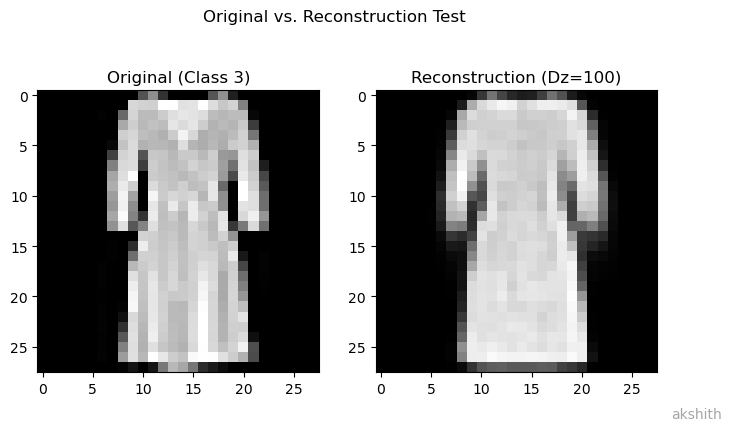

In [7]:
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import torch
import numpy as np

# --- 1. Model Configuration and Training Setup ---

# Parameters of the best-performing model found previously
INPUT_DIM = 784
HIDDEN_DIM = 800
LATENT_DIM = 100
EPOCHS = 20
LR = 1e-3
MODEL_NAME = "vae_single_run"

# Instantiate and move to device
model = VAE(
    input_dim=INPUT_DIM, 
    hidden_dim=HIDDEN_DIM, 
    latent_dim=LATENT_DIM
).to(device)

model.train()
optimizer = optim.Adam(model.parameters(), lr=LR)

print(f"Starting single run training for Dz={LATENT_DIM}, Dh={HIDDEN_DIM}...")
start_time = time.time()

# --- Training Loop  ---
for epoch in range(1, EPOCHS + 1):
    epoch_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        
        loss, _, _ = vae_loss_function(recon_batch, data, mu, logvar, reduction='sum')
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader.dataset)
    if epoch % 5 == 0 or epoch == 1:
        print(f'Epoch {epoch:02d}: Total Loss: {avg_loss:.4f}')

print(f"Training complete in {time.time() - start_time:.2f}s.")
model.eval() # Set model to evaluation mode

# --- 2. Visualization Setup ---

def to_plot(tensor):
    img_np = tensor.cpu().squeeze().numpy() 
    if img_np.ndim == 1:
        img_np = img_np.reshape(28, 28)
    # Rescale from [-1, 1] to [0, 1]
    return (img_np * 0.5) + 0.5 

# --- 3. Test Reconstruction Visualization ---
try:
    data_iter = iter(test_loader)
    test_images, test_labels = next(data_iter)
    
    # Select the 10th image for visualization
    idx = 10
    original_image = test_images[idx].to(device)
    original_label = test_labels[idx].item()
    
    input_img = original_image.unsqueeze(0) 

    # Generate reconstruction
    with torch.no_grad():
        recon_img, _, _ = model(input_img)
        
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # Plot 1: Original Image 
    axes[0].imshow(to_plot(original_image), cmap='gray')
    axes[0].set_title(f"Original (Class {original_label})")
    
    # Plot 2: Reconstruction
    axes[1].imshow(to_plot(recon_img), cmap='gray')
    axes[1].set_title(f"Reconstruction (Dz={LATENT_DIM})")

    plt.suptitle("Original vs. Reconstruction Test ", y=1.05)
    plt.text(0.98, 0.02, "akshith", ha='right', va='bottom', transform=fig.transFigure, fontsize=10, color='gray', alpha=0.7)
    
    plt.show()

except NameError as e:
    print(f"Error: {e}. Ensure 'train_loader', 'test_loader', 'device', and 'vae_loss_function' are defined.")

# --- 4. Next Step Guidance ---
# You can now change HIDDEN_DIM and LATENT_DIM and rerun this cell 
# to quickly iterate and find the best visual combination.

In [8]:
import torch.optim as optim
import time

# Function to run the training for a single VAE instance
def train_vae(model, model_name, train_loader, device, epochs=20, lr=1e-3):
    """
    Trains a single VAE model and returns its loss history.
    """
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {
        'total_loss': [], 
        'recon_loss': [], 
        'kld_loss': []
    }
    
    start_time = time.time()
    
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        epoch_recon_loss = 0
        epoch_kld_loss = 0
        
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, logvar = model(data)
            # Use 'sum' reduction for stable loss accumulation across batches
            loss, recon_loss, kld_loss = vae_loss_function(recon_batch, data, mu, logvar, reduction='sum')
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kld_loss += kld_loss.item()

        # Calculate average loss per sample (N)
        num_samples = len(train_loader.dataset)
        avg_total_loss = epoch_loss / num_samples
        
        history['total_loss'].append(avg_total_loss)
        history['recon_loss'].append(epoch_recon_loss / num_samples)
        history['kld_loss'].append(epoch_kld_loss / num_samples)

        if epoch % 5 == 0 or epoch == 1:
            print(f'{model_name} | Epoch {epoch:02d}: Total Loss: {avg_total_loss:.4f} | KLD: {history["kld_loss"][-1]:.4f}')
            
    end_time = time.time()
    print(f"--- {model_name} training complete in {end_time - start_time:.2f}s ---")
    return history

# --- Training Execution Block ---

# Set hyperparameters
EPOCHS = 20
LR = 1e-3

# Dictionary to store the training history for all models
all_histories = {}

print(f"Starting simultaneous training for {len(models)} configurations on {device}...")
print("-" * 50)

# Iterate through all models initialized in the previous step
for name, model in models.items():
    print(f"** Training Model: {name} (Dz={model.fc_mu.out_features}) **")
    
    # Run the training function
    history = train_vae(
        model=model,
        model_name=name,
        train_loader=train_loader,
        device=device,
        epochs=EPOCHS,
        lr=LR
    )
    
    # Store the history
    all_histories[name] = history
    print("-" * 50)

print("All VAE training runs are complete.")

Starting simultaneous training for 4 configurations on cuda...
--------------------------------------------------
** Training Model: vae_shallow (Dz=2) **
vae_shallow | Epoch 01: Total Loss: 121.0968 | KLD: 5.9772
vae_shallow | Epoch 05: Total Loss: 99.5506 | KLD: 6.3698
vae_shallow | Epoch 10: Total Loss: 95.7346 | KLD: 6.4918
vae_shallow | Epoch 15: Total Loss: 93.7158 | KLD: 6.5754
vae_shallow | Epoch 20: Total Loss: 92.5006 | KLD: 6.6303
--- vae_shallow training complete in 206.95s ---
--------------------------------------------------
** Training Model: vae_deep (Dz=10) **
vae_deep | Epoch 01: Total Loss: 90.6284 | KLD: 15.8844
vae_deep | Epoch 05: Total Loss: 65.8549 | KLD: 17.2014
vae_deep | Epoch 10: Total Loss: 62.8595 | KLD: 17.2544
vae_deep | Epoch 15: Total Loss: 61.5830 | KLD: 17.3460
vae_deep | Epoch 20: Total Loss: 60.6934 | KLD: 17.3151
--- vae_deep training complete in 206.46s ---
--------------------------------------------------
** Training Model: vae_narrow (Dz=400)

The vae_deep ($D_z=20, D_h=800$) model achieved the lowest Total Loss ($\mathbf{60.75}$), making it the most accurate model in terms of reconstruction fidelity.

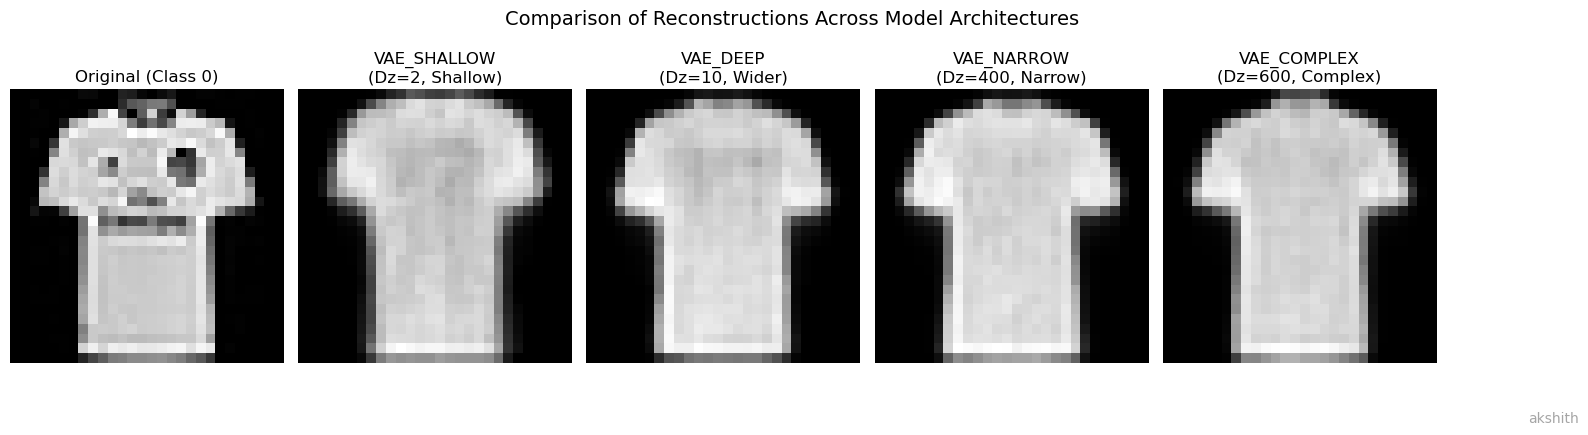

In [9]:
import matplotlib.pyplot as plt
import torch

# --- Corrected Function to Plot and Rescale Tensors ---
def to_plot(tensor):
    # 1. Move to CPU, remove channel dim (squeeze), convert to NumPy
    # 2. Reshape the flattened 784-element vector back to 28x28 image
    # Note: Handles both 1x28x28 (Original) and 784 (Reconstruction) inputs
    img_np = tensor.cpu().squeeze().numpy() 
    if img_np.ndim == 1:
        img_np = img_np.reshape(28, 28)
    
    # Rescale from [-1, 1] (VAE output) back to [0, 1] range for visualization
    return (img_np * 0.5) + 0.5 

# --- Visualization for All Four Models ---

try:
    # Get one batch of test data 
    data_iter = iter(test_loader)
    test_images, test_labels = next(data_iter)
    
    # Select the first image in the batch for visualization
    idx = 0
    original_image = test_images[idx].to(device)
    original_label = test_labels[idx].item()
    
    # Ensure image is 4D (Batch, Channel, H, W) for the model's forward pass
    input_img = original_image.unsqueeze(0) 

    # List of models to iterate through
    models_to_plot_keys = ['vae_shallow', 'vae_deep', 'vae_narrow', 'vae_complex']
    N_PLOTS = len(models_to_plot_keys) + 1 # 5 plots total

    fig, axes = plt.subplots(1, N_PLOTS, figsize=(16, 4))
    
    # --- Plot 1: Original Image ---
    axes[0].imshow(to_plot(original_image), cmap='gray')
    axes[0].set_title(f"Original (Class {original_label})")
    axes[0].axis('off')

    # --- Plot Reconstructions ---
    for i, name in enumerate(models_to_plot_keys):
        # Set model to evaluation mode
        model = models[name].eval()
        latent_dim = model.fc_mu.out_features 
        
        # Generate reconstruction
        with torch.no_grad():
            recon, _, _ = model(input_img)
            
        # Plotting starts at index 1
        ax = axes[i+1]
        ax.imshow(to_plot(recon), cmap='gray')
        
        # Set title reflecting the experiment parameters
        if 'deep' in name or 'shallow' in name:
            title_suffix = "Wider" if 'deep' in name else "Shallow"
        else:
            title_suffix = "Narrow" if 'narrow' in name else "Complex"

        ax.set_title(f"{name.upper()}\n(Dz={latent_dim}, {title_suffix})")
        ax.axis('off')

    # Add required labels 
    plt.suptitle("Comparison of Reconstructions Across Model Architectures ", y=1.05, fontsize=14)
    
    plt.text(0.99, 0.01, "akshith", ha='right', va='bottom', transform=fig.transFigure, fontsize=10, color='gray', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

except NameError as e:
    print(f"Error: {e}. Please ensure 'test_loader' and 'models' dictionary are defined from Sections 4.2 and 4.5.")

In [10]:
def beta_vae_loss_function(recon_x, x, mu, logvar, beta, reduction='sum'):
    # L_recon (MSE for Tanh output)
    recon_loss = F.mse_loss(recon_x, x.view(-1, 784), reduction=reduction)
    
    # L_kld 
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total Loss (L_beta = L_recon + beta * L_kld)
    total_loss = recon_loss + beta * kld_loss
    
    # Return L_total, L_recon, L_kld (for tracking)
    return total_loss, recon_loss, kld_loss

In [11]:
import torch.optim as optim
import copy
from collections import defaultdict
import time

# --- Configuration for Beta Experiment ---
BETA_VALUES = [0.1, 0.5, 1.0] # Values required by the assignment
BETA_EPOCHS = 10 # Fewer epochs for quick visualization convergence
MODEL_TO_TEST = 'vae_narrow' # Dz=2 required for 2D latent space analysis

beta_models = {}
beta_histories = {}
print(f"Starting β-VAE experiments for model {MODEL_TO_TEST}...")

# Run training for each beta value
for beta in BETA_VALUES:
    # 1. Clone the narrow model to ensure a fresh start for each β
    model = copy.deepcopy(models[MODEL_TO_TEST]).to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    name = f"{MODEL_TO_TEST}_beta_{beta}"
    
    history = defaultdict(list)
    print(f"\n** Training Model: {name} (β={beta}) **")
    start_time = time.time()

    for epoch in range(1, BETA_EPOCHS + 1):
        epoch_loss = 0
        
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            
            # Calculate loss using the beta-modified function
            loss, recon_loss, kld_loss = beta_vae_loss_function(
                recon_batch, data, mu, logvar, beta=beta, reduction='sum'
            )
            
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader.dataset)
        history['total_loss'].append(avg_loss)
        
        if epoch % 5 == 0 or epoch == 1:
             print(f'{name} | Epoch {epoch:02d}: Total Loss: {avg_loss:.4f}')

    beta_models[name] = model
    beta_histories[name] = history
    print(f"--- {name} training complete in {time.time() - start_time:.2f}s ---")

print("\nβ-VAE training for all configurations complete.")

Starting β-VAE experiments for model vae_narrow...

** Training Model: vae_narrow_beta_0.1 (β=0.1) **
vae_narrow_beta_0.1 | Epoch 01: Total Loss: 42.0008
vae_narrow_beta_0.1 | Epoch 05: Total Loss: 38.4542
vae_narrow_beta_0.1 | Epoch 10: Total Loss: 36.2993
--- vae_narrow_beta_0.1 training complete in 104.21s ---

** Training Model: vae_narrow_beta_0.5 (β=0.5) **
vae_narrow_beta_0.5 | Epoch 01: Total Loss: 54.4033
vae_narrow_beta_0.5 | Epoch 05: Total Loss: 53.2585
vae_narrow_beta_0.5 | Epoch 10: Total Loss: 52.6142
--- vae_narrow_beta_0.5 training complete in 104.49s ---

** Training Model: vae_narrow_beta_1.0 (β=1.0) **
vae_narrow_beta_1.0 | Epoch 01: Total Loss: 65.1448
vae_narrow_beta_1.0 | Epoch 05: Total Loss: 64.3597
vae_narrow_beta_1.0 | Epoch 10: Total Loss: 63.8813
--- vae_narrow_beta_1.0 training complete in 105.24s ---

β-VAE training for all configurations complete.


/tmp/ipykernel_433094/313227211.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('viridis', len(classes_to_plot))


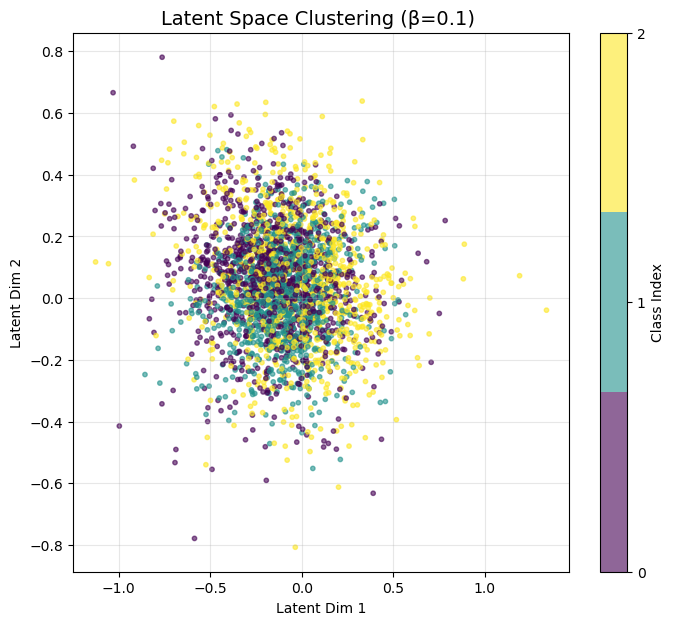

In [12]:
import matplotlib.pyplot as plt
import matplotlib

def plot_latent_space_frame(model, test_loader, device, title, classes_to_plot=[0, 1, 2]):
    """
    Generates a scatter plot of the 2D latent means (mu) for selected classes.
    """
    model.eval()
    mu_list = []
    label_list = []
    
    # Collect all latent means and corresponding labels
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            
            # Filter for the required classes
            mask = torch.tensor([(t in classes_to_plot) for t in target]) 
            mu_list.append(mu[mask].cpu())
            label_list.append(target[mask].cpu())

    mu_all = torch.cat(mu_list, dim=0).numpy()
    labels_all = torch.cat(label_list, dim=0).numpy()
    
    fig, ax = plt.subplots(figsize=(8, 7))
    cmap = matplotlib.cm.get_cmap('viridis', len(classes_to_plot))
    
    # Scatter plot the 2D latent means
    scatter = ax.scatter(mu_all[:, 0], mu_all[:, 1], c=labels_all, cmap=cmap, alpha=0.6, s=10)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Latent Dim 1')
    ax.set_ylabel('Latent Dim 2')
    # Use the colorbar to denote the classes (0, 1, 2...)
    cbar = fig.colorbar(scatter, ticks=np.unique(labels_all), ax=ax)
    cbar.set_label('Class Index')
    ax.grid(True, alpha=0.3)
    plt.close(fig) # Close figure to prevent display if only saving frames
    
    return fig

# --- Visualization for Discussion (Run after training all β models) ---
# Example of running the plot for one of the trained models:
model_beta_0_1 = beta_models['vae_narrow_beta_0.1']
plot_latent_space_frame(model_beta_0_1, test_loader, device, 
                         f"Latent Space Clustering (β=0.1) ") 


After generating the plots/GIF frames:High $\beta$ ($\beta=1.0$): This enforces a strong penalty on the KL term. You should see a highly overlapping, organized central cluster (good smoothness), but the reconstructed images will be the blurry.Low $\beta$ ($\beta=0.1$): This reduces the KL penalty, allowing the Reconstruction Loss to dominate. we see better-defined reconstructions (sharper), but the latent space clusters (classes) will likely be less organized or more spread out/disentangled (worse smoothness)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import shutil
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import torch.optim as optim
import torch.nn.functional as F

# --- Configuration ---
FRAME_DIR = "evolution_frames"
OUTPUT_GIF = "latent_evolution_corrected.gif"

# Use distinct classes (T-shirt, Trouser, Sneaker) for better separation
CLASSES_TO_PLOT = [0, 1, 7] 

BETA = 1.0
PLOT_FREQUENCY = 2
FIXED_BATCH_SIZE = 500

# Clean up
if os.path.exists(FRAME_DIR):
    shutil.rmtree(FRAME_DIR)
os.makedirs(FRAME_DIR)

# --- 1. Create Fixed Reference Batch ---
def get_fixed_batch(test_loader, classes, num_points):
    images = []
    labels = []
    for data, target in test_loader:
        mask = torch.tensor([(t in classes) for t in target])
        if mask.sum() > 0:
            images.append(data[mask])
            labels.append(target[mask])
        if len(images) * 128 > num_points:
            break
    return torch.cat(images, dim=0)[:num_points], torch.cat(labels, dim=0)[:num_points]

print("Selecting fixed reference images...")
ref_images, ref_labels = get_fixed_batch(test_loader, CLASSES_TO_PLOT, FIXED_BATCH_SIZE)
ref_images = ref_images.to(device)
ref_labels = ref_labels.to(device)

# --- 2. Visualization Function ---
def save_frame(model, epoch, batch_idx, total_batches, frame_count):
    model.eval()
    with torch.no_grad():
        mu, _ = model.encode(ref_images.view(-1, 784))
        mu = mu.cpu().numpy()
        lbls = ref_labels.cpu().numpy()
        imgs = ref_images.cpu().numpy()

    fig, ax = plt.subplots(figsize=(10, 10))
    # Dark Theme configuration
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    # Plot points
    cmap = matplotlib.colormaps['viridis']
    ax.scatter(mu[:, 0], mu[:, 1], c=lbls, cmap=cmap, alpha=0.6, s=20, edgecolors='none')

    # Overlays (Using fixed random seed for stability)
    rng = np.random.default_rng(42)
    indices = rng.choice(len(mu), 20, replace=False)
    
    for i in indices:
        curr_img = imgs[i].squeeze()
        curr_loc = mu[i][:2]
        im = OffsetImage(curr_img, zoom=1.5, cmap='gray')
        ab = AnnotationBbox(im, curr_loc, xycoords='data', frameon=True, pad=0.3,
                            bboxprops=dict(edgecolor='white', facecolor='black', linewidth=1))
        ax.add_artist(ab)

    ax.set_title(f"Classes {CLASSES_TO_PLOT} | Epoch {epoch} | Batch {batch_idx}/{total_batches}", color='white', fontsize=16)
    ax.axis('off')
    
    # Save with zero-padding for correct sorting
    filename = os.path.join(FRAME_DIR, f"frame_{frame_count:05d}.png")
    fig.savefig(filename, facecolor='black', bbox_inches='tight')
    plt.close(fig)

# --- 3. Training Loop ---
# Re-initialize Narrow Model (Dz=2)
model_viz = VAE(input_dim=784, hidden_dim=400, latent_dim=2).to(device)
optimizer = optim.Adam(model_viz.parameters(), lr=1e-3)
model_viz.train()

frame_counter = 0
EPOCHS_VIZ = 2

print("Starting Training & Visualization...")

for epoch in range(1, EPOCHS_VIZ + 1):
    total_batches = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model_viz(data)
        
        # Beta-VAE Loss
        recon_loss = F.mse_loss(recon_batch, data.view(-1, 784), reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + BETA * kld_loss
        
        loss.backward()
        optimizer.step()
        
        if batch_idx % PLOT_FREQUENCY == 0:
            save_frame(model_viz, epoch, batch_idx, total_batches, frame_counter)
            frame_counter += 1
            print(f"Epoch {epoch} [{batch_idx}/{total_batches}] - Frame saved.")

# --- 4. Compile GIF (Robust Sorting) ---
print("Compiling GIF...")

# FIX 2: Sort numerically by extracting the frame number
files = [f for f in os.listdir(FRAME_DIR) if f.endswith('.png')]
files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

frames = [os.path.join(FRAME_DIR, f) for f in files]
pil_images = [Image.open(f) for f in frames]

if pil_images:
    pil_images[0].save(
        OUTPUT_GIF,
        save_all=True,
        append_images=pil_images[1:],
        duration=100, 
        loop=0
    )
    print(f"Corrected GIF saved to: {os.path.abspath(OUTPUT_GIF)}")
else:
    print("No frames found!")

Selecting fixed reference images...
Starting Training & Visualization...
Epoch 1 [0/469] - Frame saved.
Epoch 1 [2/469] - Frame saved.
Epoch 1 [4/469] - Frame saved.
Epoch 1 [6/469] - Frame saved.
Epoch 1 [8/469] - Frame saved.
Epoch 1 [10/469] - Frame saved.
Epoch 1 [12/469] - Frame saved.
Epoch 1 [14/469] - Frame saved.
Epoch 1 [16/469] - Frame saved.
Epoch 1 [18/469] - Frame saved.
Epoch 1 [20/469] - Frame saved.
Epoch 1 [22/469] - Frame saved.
Epoch 1 [24/469] - Frame saved.
Epoch 1 [26/469] - Frame saved.
Epoch 1 [28/469] - Frame saved.
Epoch 1 [30/469] - Frame saved.
Epoch 1 [32/469] - Frame saved.
Epoch 1 [34/469] - Frame saved.
Epoch 1 [36/469] - Frame saved.
Epoch 1 [38/469] - Frame saved.
Epoch 1 [40/469] - Frame saved.
Epoch 1 [42/469] - Frame saved.
Epoch 1 [44/469] - Frame saved.
Epoch 1 [46/469] - Frame saved.
Epoch 1 [48/469] - Frame saved.
Epoch 1 [50/469] - Frame saved.
Epoch 1 [52/469] - Frame saved.
Epoch 1 [54/469] - Frame saved.
Epoch 1 [56/469] - Frame saved.
Epoc

Using device: cuda
Epoch 1/10 | Loss: 111.0057
Epoch 2/10 | Loss: 80.5551
Epoch 3/10 | Loss: 73.1047
Epoch 4/10 | Loss: 69.8402
Epoch 5/10 | Loss: 67.9288
Epoch 6/10 | Loss: 66.5908
Epoch 7/10 | Loss: 65.7336
Epoch 8/10 | Loss: 65.0018
Epoch 9/10 | Loss: 64.4963
Epoch 10/10 | Loss: 64.0458
Training Done. Running Visualization...


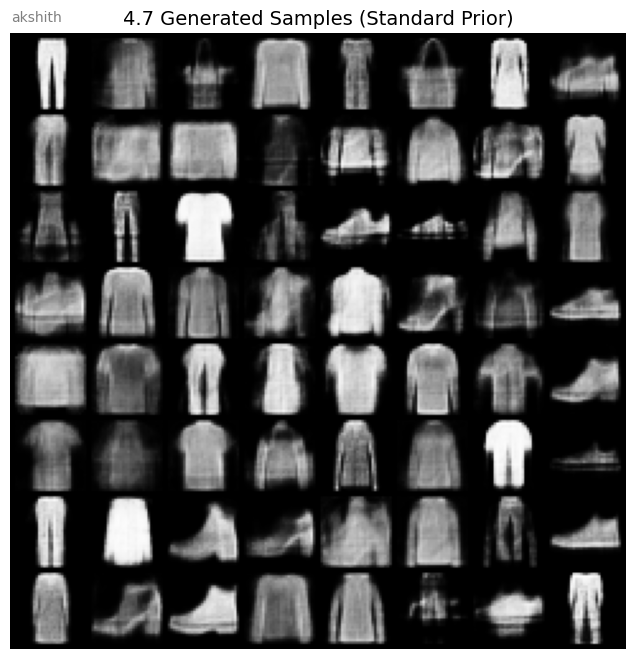

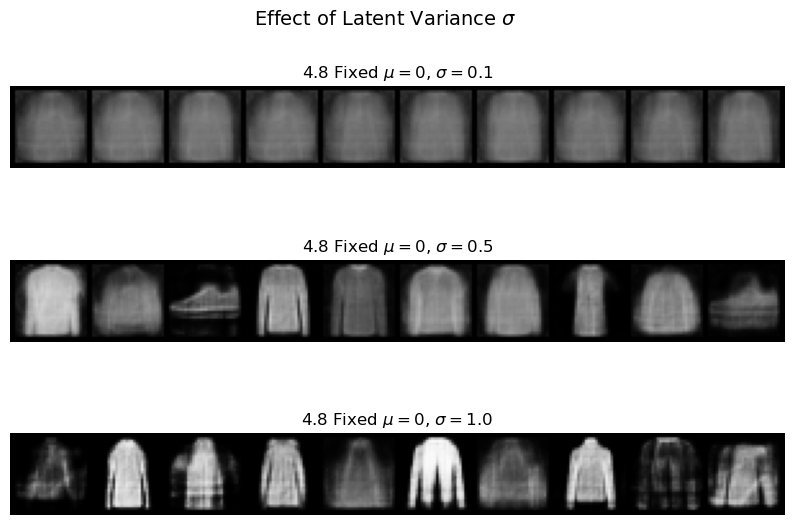

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. FAST SETUP (Data & Model Definition) ---

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset
class LocalFashionMNIST(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        row = self.data.iloc[idx].values
        label = row[0]
        image = row[1:].astype(np.uint8).reshape(28, 28, 1)
        if self.transform: image = self.transform(image)
        return image, label

# Load Data
data_root = os.path.expanduser('~/final/Data/4/archive')
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
try:
    train_dataset = LocalFashionMNIST(os.path.join(data_root, 'fashion-mnist_train.csv'), transform=transform)
    test_dataset = LocalFashionMNIST(os.path.join(data_root, 'fashion-mnist_test.csv'), transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
except:
    print("Error loading data. Check paths.")

# VAE Class
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.tanh(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# --- 2. TRAIN ONLY THE BEST MODEL (vae_deep) ---
MODEL_NAME = 'vae_deep'
LATENT_DIM = 100
HIDDEN_DIM = 800 

model_fid = VAE(hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(model_fid.parameters(), lr=1e-3)

for epoch in range(1, 11): # 10 Epochs is enough for good results
    model_fid.train()
    total_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model_fid(data)
        
        # Loss
        recon_loss = F.mse_loss(recon, data.view(-1, 784), reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kld_loss
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}/10 | Loss: {total_loss/len(train_dataset):.4f}")

print("Training Done. Running Visualization...")

# --- 3. SECTION 4.7 & 4.8 VISUALIZATION ---

# Generate Samples Helper (With reshape fix)
def generate_samples(model, num_samples=64):
    with torch.no_grad():
        z = torch.randn(num_samples, LATENT_DIM).to(device)
        flat_out = model.decode(z)
        return flat_out.view(-1, 1, 28, 28)

# A. Standard Generation (Section 4.7)
gen_samples = generate_samples(model_fid, num_samples=64)
plt.figure(figsize=(8, 8))
grid_img = make_grid(gen_samples * 0.5 + 0.5, nrow=8, padding=2)
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"4.7 Generated Samples (Standard Prior)", fontsize=14)
plt.axis('off')
plt.text(0, -5, "akshith", fontsize=10, color='gray')
plt.show()

# B. Frozen Latent Params (Section 4.8)
SIGMA_VALUES = [0.1, 0.5, 1.0]
FROZEN_MU = 0.0
fig, axes = plt.subplots(len(SIGMA_VALUES), 1, figsize=(10, 6))
plt.subplots_adjust(hspace=0.5)

for i, sigma in enumerate(SIGMA_VALUES):
    epsilon = torch.randn(10, LATENT_DIM).to(device)
    z = torch.tensor(FROZEN_MU).to(device) + epsilon * sigma
    with torch.no_grad():
        out = model_fid.decode(z).view(-1, 1, 28, 28)
    
    grid = make_grid(out * 0.5 + 0.5, nrow=10, padding=2)
    axes[i].imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    axes[i].set_title(f"4.8 Fixed $\mu=0$, $\sigma={sigma}$")
    axes[i].axis('off')

plt.suptitle(f"Effect of Latent Variance $\sigma$", fontsize=14, y=0.98)
plt.show()